# Artificial Time Series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 1. AR (Autoregressive) Processes

$\color{red}{AR}$ (autoregressive) model is simply a linear combination of $\color{red}{p}$ lags with **normally distributed residuals**

$$Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \dots + \beta_{\color{red}{p}} Y_{t-\color{red}{p}} + \epsilon_t$$

📺 [First, watch this 5min example of AR process: A change of oil price](https://www.youtube.com/watch?v=AN0a58F6cxA)

In [7]:
def plot_ar_process(ar1, ar2=0, diff=0, n=500, mu=0, sigma=1, show_plot=True, return_y=False):
    '''
    Plot an auto-regressive time series, as well as its ACF/PACF plots
    '''
    X=np.arange(n)
    y_list = []
    y0 = 0
    y1 = 0
    for i in range(n):
        # build an AR process of params (beta_1, beta_2) = (ar1, ar2)
        # With noise epsilon(t) = Normal(mu, sigma)
        y_new = ar1 * y1 + ar2* y0 + scipy.stats.norm.rvs(mu,sigma)
        y0 = y1
        y1 = y_new.copy()
        y_list.append(y0)
    if diff > 0:
        for i in range(diff):
            y_list = list(pd.Series(y_list).diff())
        y_list = y_list[diff:]
        X = X[diff:]
    if show_plot:
        fig = plt.figure(figsize=(20,10))
        ax1 = fig.add_subplot(2,1,1)
        ax1.set_title(f'Auto-regressive stationary TS with lagged coefs = ({ar1}, {ar2})')
        ax2 = fig.add_subplot(2,2,3)
        ax3 = fig.add_subplot(2,2,4)
        ax1.plot(X,y_list)
        plot_acf(y_list, lags=50, auto_ylims=True,ax=ax2);
        plot_pacf(y_list, lags=50, method='ywm', auto_ylims=True, ax=ax3, color='r');
        plt.show()
    if return_y:
        return y_list

### Stationary AR Processes

👇 Try to understand the code above, then run it for $\beta_1$ < 1, let's say 0.95 (`ar1=0.95`) and `n=200`.

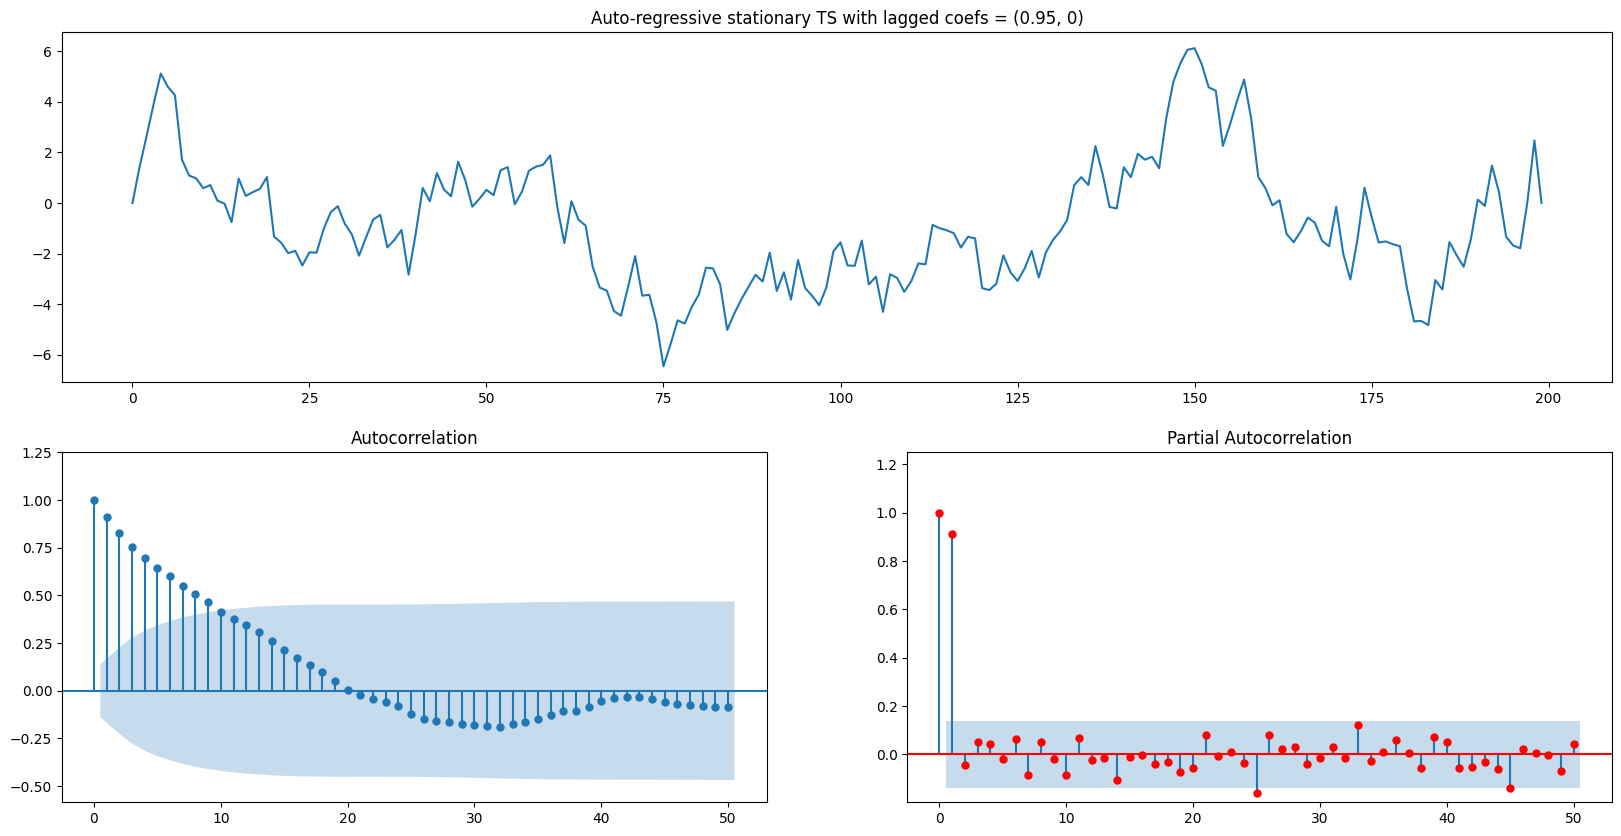

In [8]:
plot_ar_process(ar1=0.95, n=200)

❓️ Try to answer the following questions:

1. Does the time series look stationary? Why?
2. Do you see the AR1 term in your PACF?
3. What is the relationship between subsequent terms in the normal ACF?

<details>
    <summary>Answers</summary>

1. The time series has an AR term &lt; 1, and will thus not show a growing trend but regress toward the mean; it is stationary 
2. The second peak in the PACF should be around 0.95 (corresponding to our AR(1) term). The first peak is <b>always</b> 1.0
3. Each peak in the ACF should be approximately 0.95 times the peak before it; the propagation of the AR term can be seen far into the future for the ACF, but this effect has been removed in the PACF
</details>

### Influence of Sample Size

👇 Plot the same curves but with n=10000

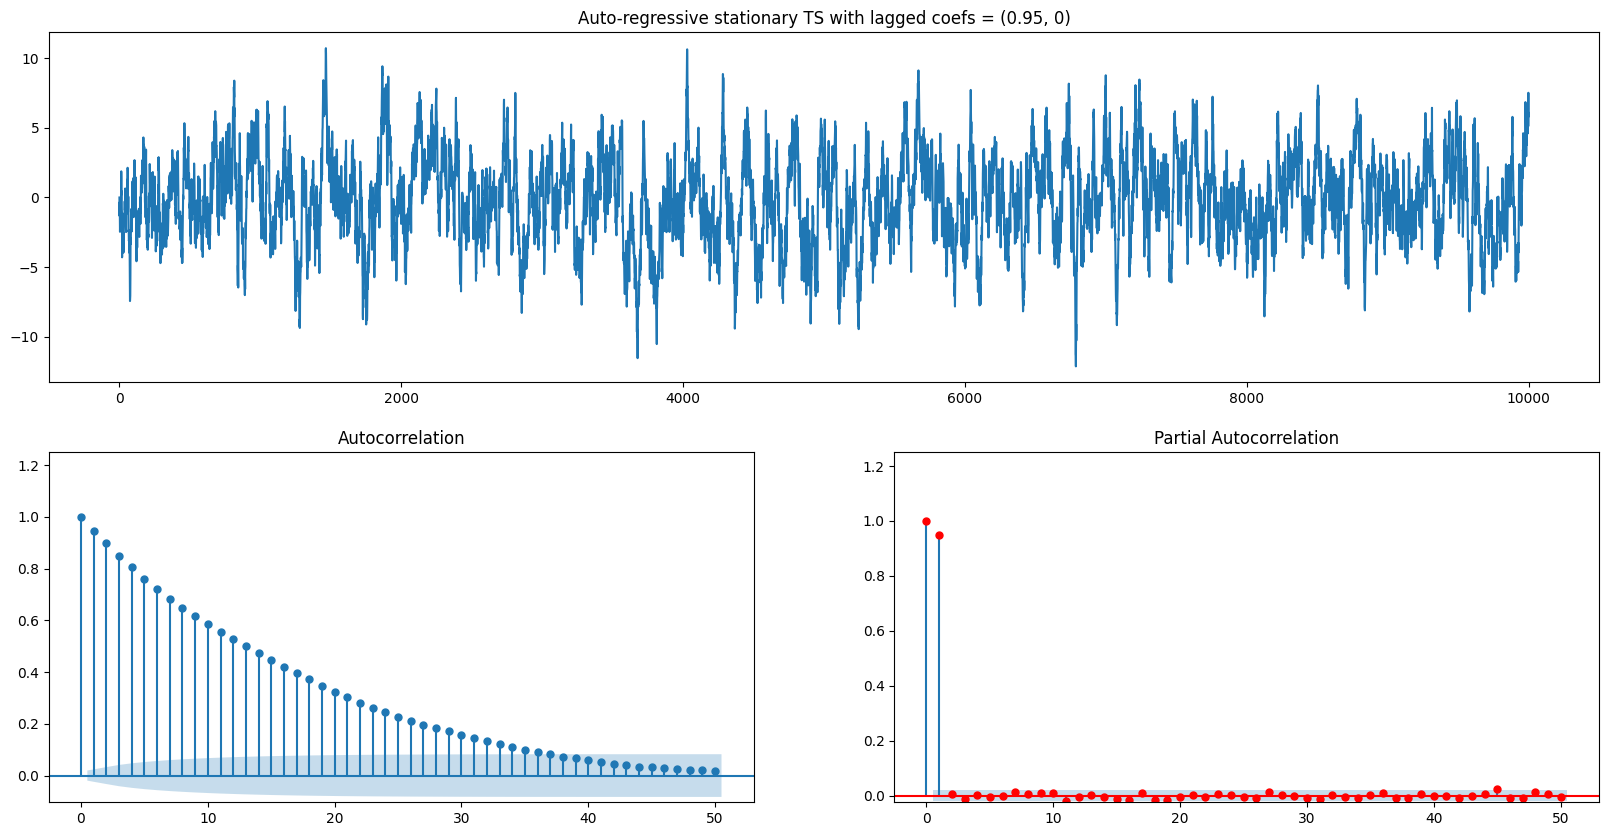

In [9]:
plot_ar_process(ar1=0.95, n=10000)


❓️ Questions
1. What changed about the ACF and PACF (*hint: look at the blue cone*)?
2. Does this make sense to you? Remember what you know about sample sizes and confidence intervals!

<details>
    <summary>Answers</summary>

1. The blue cones have gotten smaller, as have the insignificant peaks in the PACF; the blue cones are the confidence intervals
2. Increased sample size will make our confidence intervals smaller (Central Limit Theorem!)
</details>

### Non-Stationary AR Process

Now let's look at what happens when $\beta_1$ >= 1.

👇 Plot the time series and (P)ACF for $\beta_1$ = 1.01 and n=200. Set `np.random.seed(1)` at the top of your cell to reproduce our results

You should now see a trend.

In [10]:
np.random.seed(1)

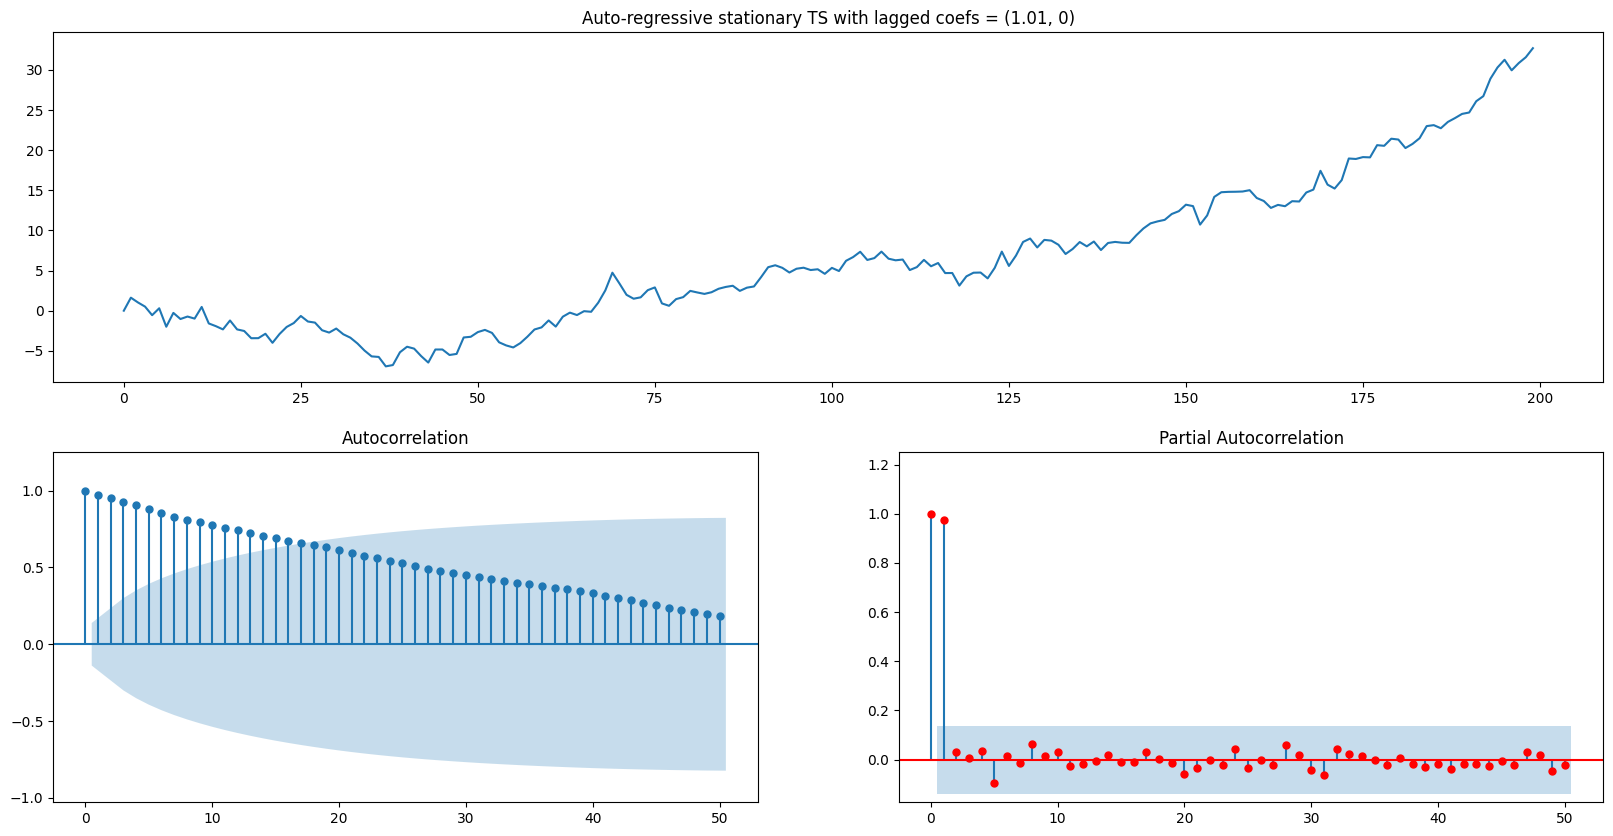

In [11]:
plot_ar_process(ar1=1.01, n=200)

❓️Questions:
1. Why do you see a trend?
2. Is the time series still stationary?
3. If not, what would you do to make it stationary?

<details>
    <summary>Answers</summary>

1. An AR term of 1 or more (or a combination of AR terms that add up to approximately 1) will not regress to the mean, and show a trend instead. The model is said to have "unit root". If your AR term is larger than 1, it will grow exponentially, as each value of Y will be bigger than the one before.
2. The time series is not stationary anymore (it has unit root, which can be tested with a unit root test like the ADF), since it has a time-dependent mean (the mean changes over time, i.e. it has a trend).
3. We can de-trend or difference the time series. With such exponential behavior, it is also helpful to work with the logarithm of your time series.
</details>

### Exponential Behavior

👇 Plot the same time series for n=500, keep the same random seed

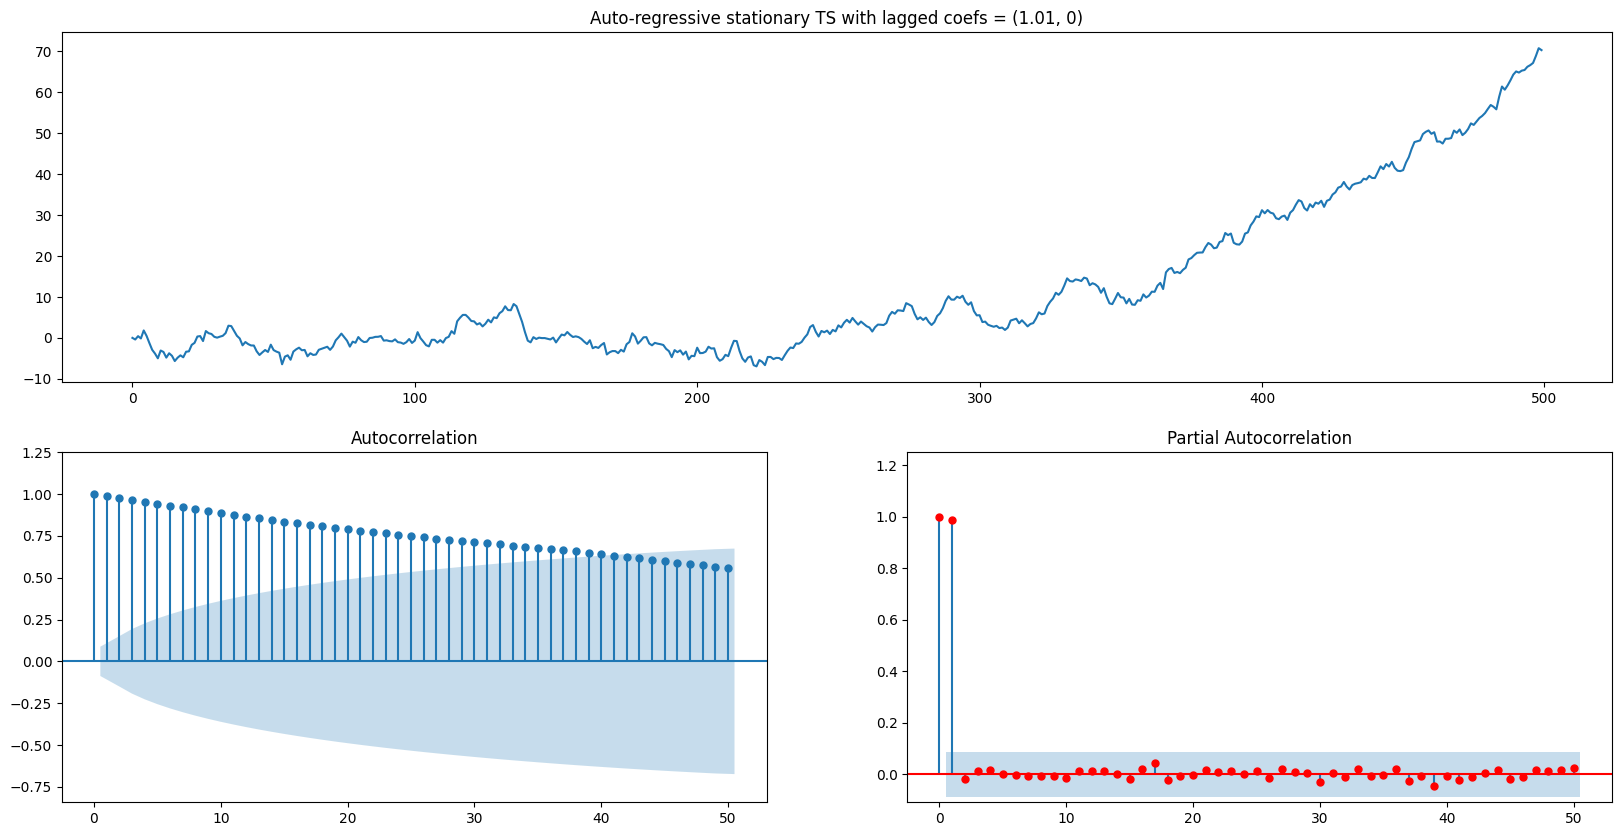

In [12]:
plot_ar_process(ar1=1.01, n=500)

❓️Why does the time series quickly becomes exponential?

<details>
    <summary>Answer</summary>
Each value of Y will be its previous value multiplied by 1.01, which after a while will grow to be very large numbers. This is called exponential behavior.
    
💡 This is also why 1% more annual return of an investment makes a bit of a difference after a few years :)
</details>

<br>

👇 Keeping n=200 and increasing $\beta_1$ slightly (say, to 1.1) should result in similar behavior. Try it (keep random seed 1)!

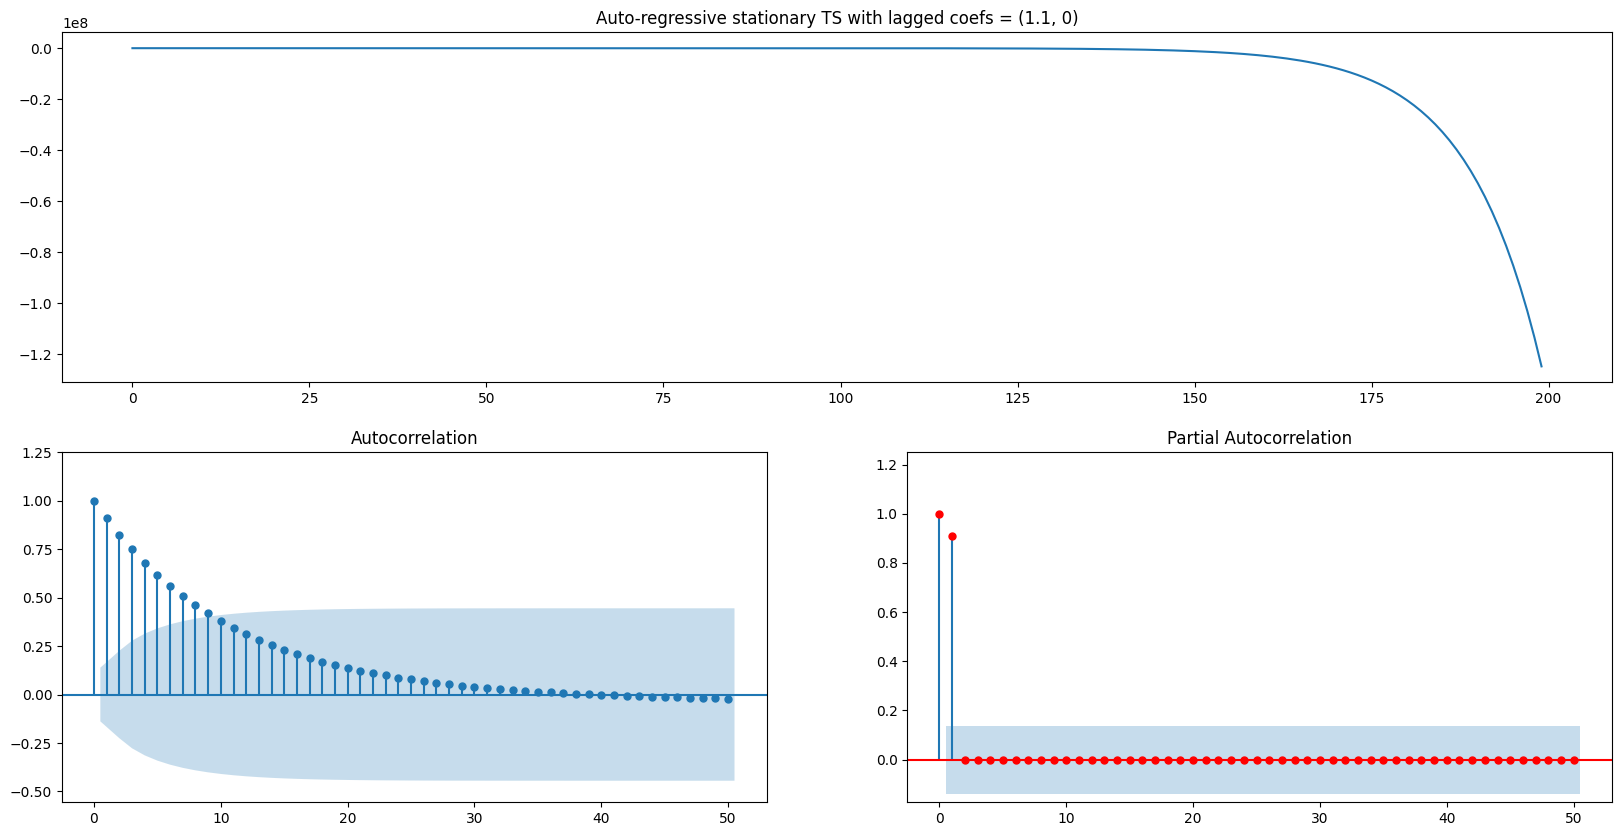

In [14]:
np.random.seed(1)
plot_ar_process(ar1=1.1, n=200)

If you kept the random seed at 1, you should find that with ar1=1.1 the time series will now be exponentially decreasing.

❓️Why is that?


<details>
    <summary>Answer</summary>
Some small fluctuation in the beginning made some value of y negative, which then quickly escaped to negative infinity. 
    
💡 This type of behavior (tiny fluctuations having a huge impact) plays an important role in chaos theory and the [Butterfly effect](https://en.wikipedia.org/wiki/Butterfly_effect).
</details>

☝️ **Comments** 

This behavior is true in nature for any process with a true exponential behavior (i.e. AR coefficients larger than 1).

Many processes in real life will be exponential in the long run, but seem like they only have a linear trend in the short run (like when we increased n to 500). If you clearly see exponential behavior in your time series, you can use a log-transformation to remove it!

Another way to "control" this behavior is to add a negative AR(2) term.

### Competing AR Terms

👇 Plot the same curve with $\beta_1$ = 1.1 and n=200, but add an AR(2) term of $\beta_2$ = -0.5. Keep `np.random.seed(1)`.

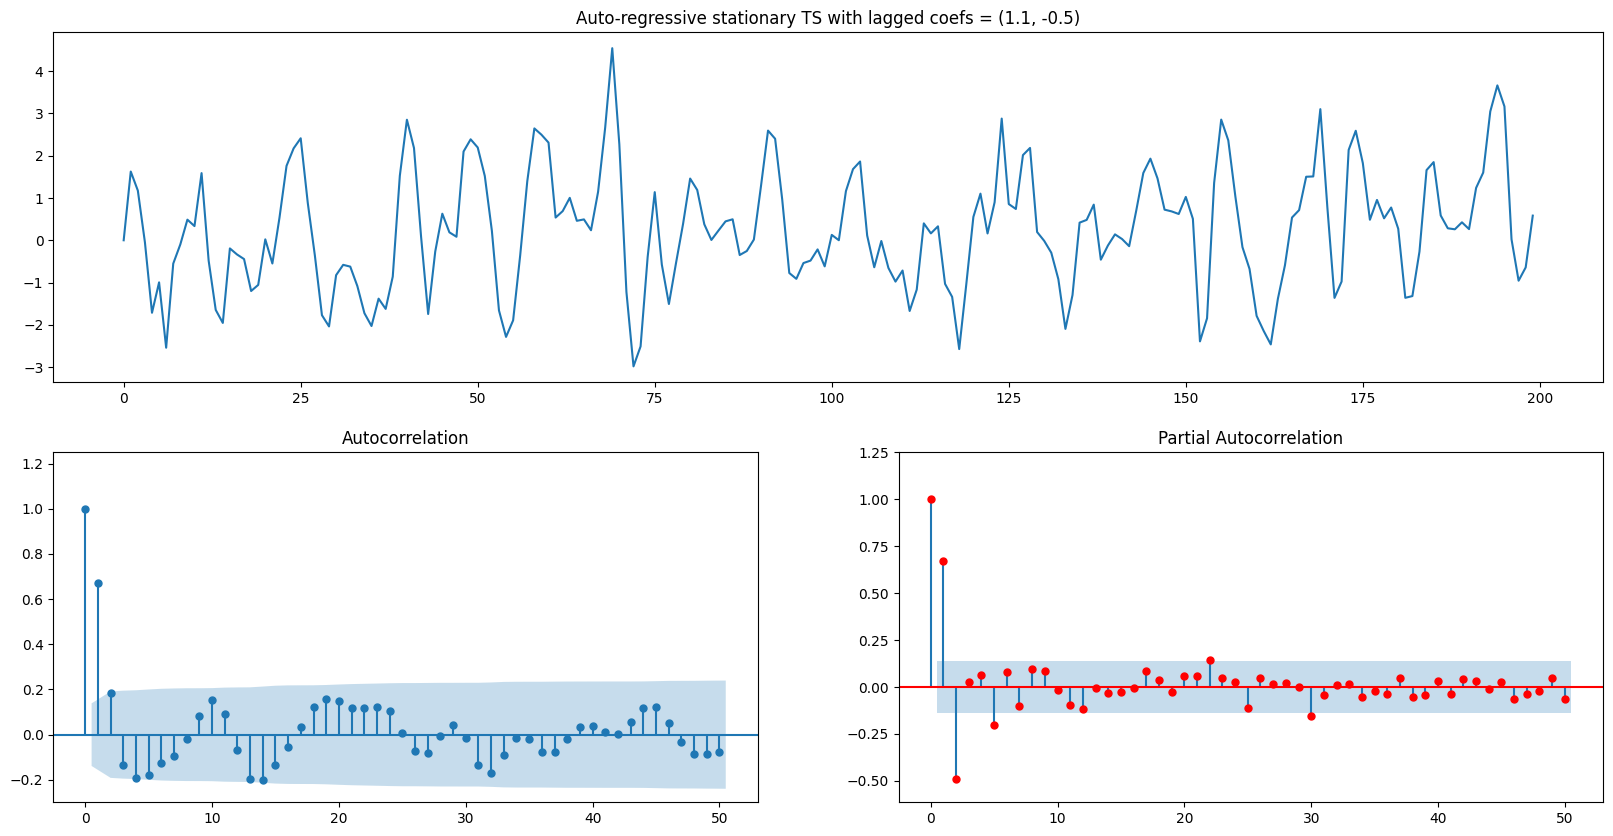

In [15]:
np.random.seed(1)
plot_ar_process(ar1=1.1,ar2=-0.5, n=200)

Think about this!
- The AR(1) term is trying to make the time series get bigger and bigger in one direction, because every y is larger than the y at t-1.
- The AR(2) term counteracts this by subtracting a fraction of the value of y at t-2.

☝️ The ACF should now show oscillatory behavior instead of an exponential decrease.

☝️ The PACF should show a positive term followed by a negative term.

❓️Is this TS stationary?

<details>
    <summary>Answer</summary>
Yes, it is!

The second AR term negates the exponential behavior of the first term. The time series will regress toward the mean, because the sum of AR coefficients is less than 1.
</details>

### Negative AR Terms

Having only a negative AR(1) term will give us an even stronger oscillatory behavior, without any of the "stickiness" of the mixed process we just created. The AR(1) term created "stickiness", the AR(2) term created "oscillation".

Stickiness is the behavior of a time series staying at a given level for a period of time. This is due to the positive AR(1) coefficient.

👇 Plot the graphs for `ar1 = -0.5` (no AR(2) term). Convince yourself that the behavior is strongly oscillatory but has no stickiness.

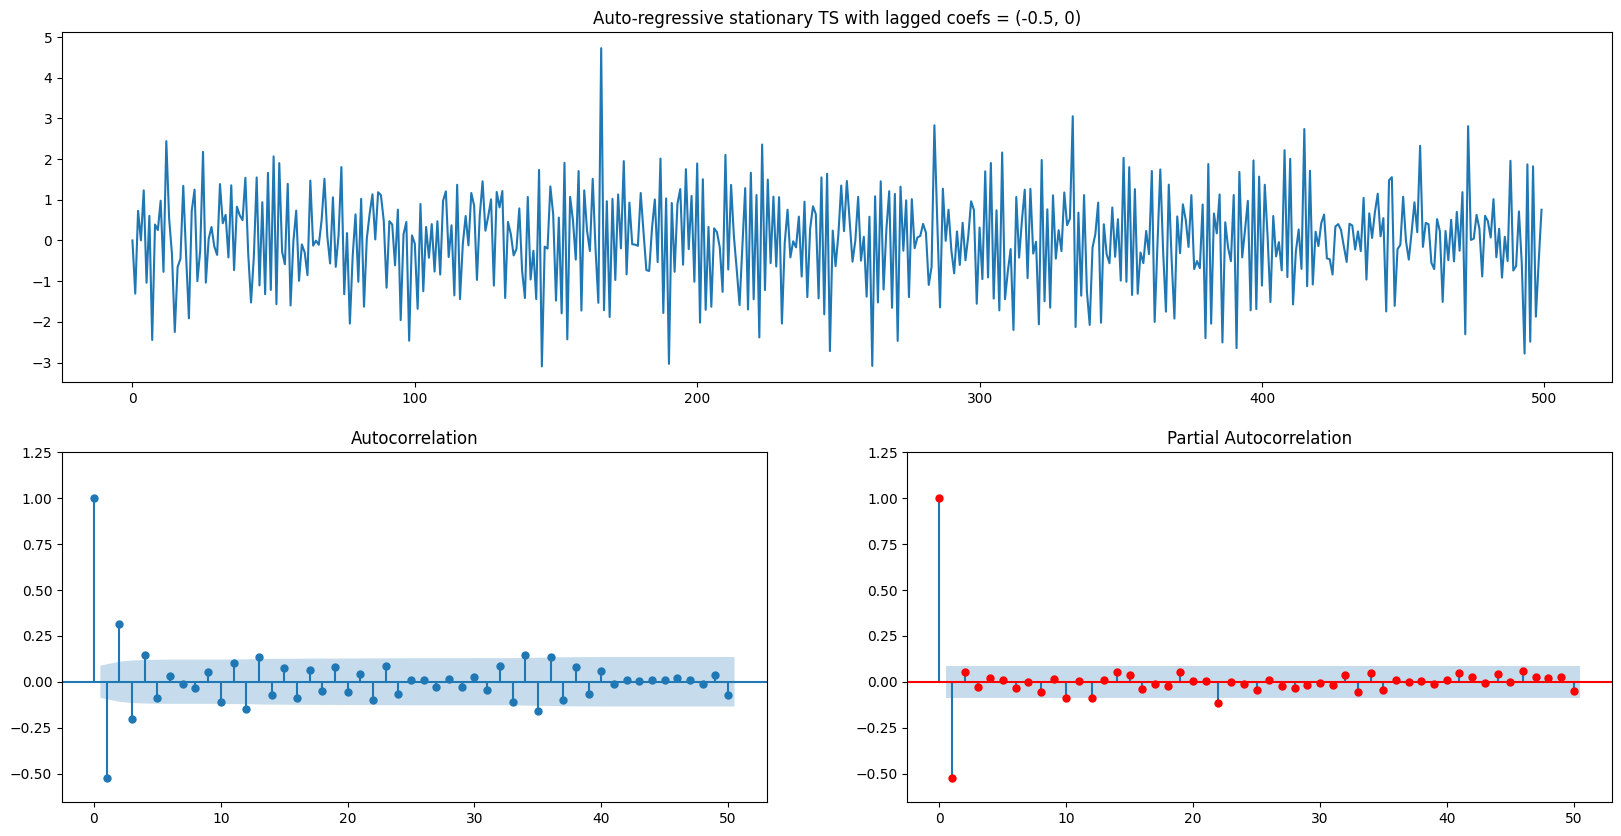

In [17]:
plot_ar_process(ar1=-0.5)

Let's summarize:
- $\beta_{1} = 0$ ➔ white noise
- $0 < \beta_{1} < 1$ ➔ "sticky" time series regressing to the mean
- $\beta_{1} = 1$ ➔ random walk/linear trend
- $\beta_{1} > 1$ ➔ exponential trend
- $\beta_{1} < 0$ ➔ oscillations
- $\beta_{1} < -1$ ➔ exponential oscillations

- Significant terms at higher lags indicate seasonality.


### Additive AR Terms

What if we have two positive AR terms that are each smaller than 1?

👇 Plot the time series with `ar1` = `ar2` = `0.5` and `n=1000` points. Set np.random.seed(1).

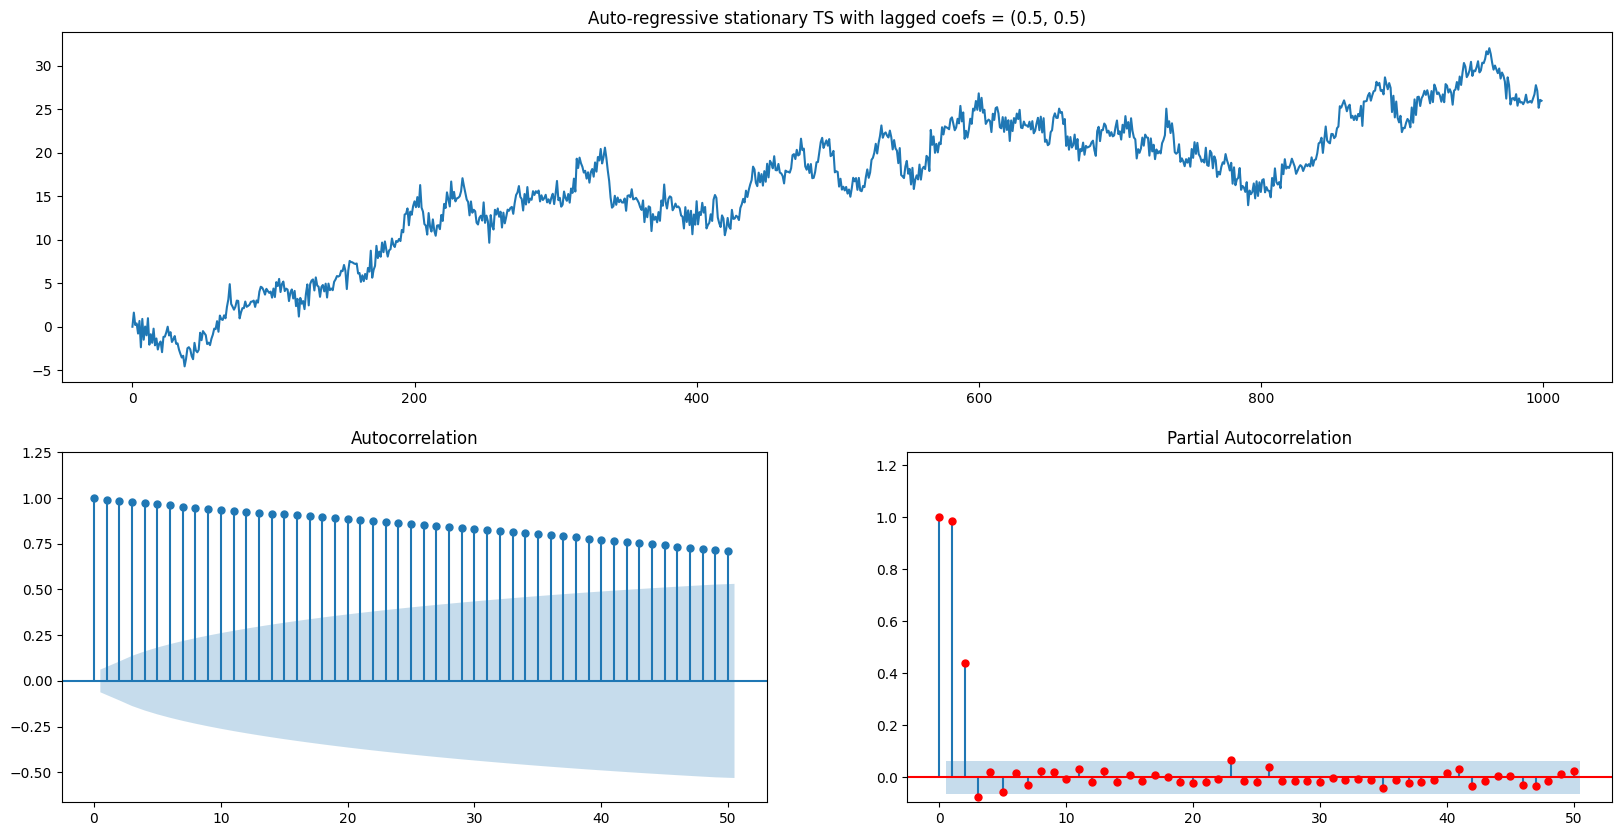

In [18]:
np.random.seed(1)
plot_ar_process(ar1=0.5,ar2=0.5, n=1000)

☝️ Look at the PACF. The AR(1) term is actually close to 1 and not 0.5 as we could have expected. The PACF method is not perfect. Similarly to Linear Regression, we can have problems with interpretation of the coefficients because of collinearity, especially if the coefficients are on a similar scale.

☝️ If you look at the ACF, it simply looks like a time series with a single AR term close to 1. There is almost no way to differentiate it from an AR(1) model.

❓️ Questions:
1. Does this time series look stationary to you?
2. What can we do to make it stationary?

<details>
    <summary>Answers</summary>
    
1. No! It has a growing mean (trend) because the AR(1) and AR(2) terms add up to 1.
2. We can de-trend or difference the time series.
</details>

### Differencing a Non-Stationary AR Time Series

👇 Replot the same time series and (P)ACFs, but add diff=1

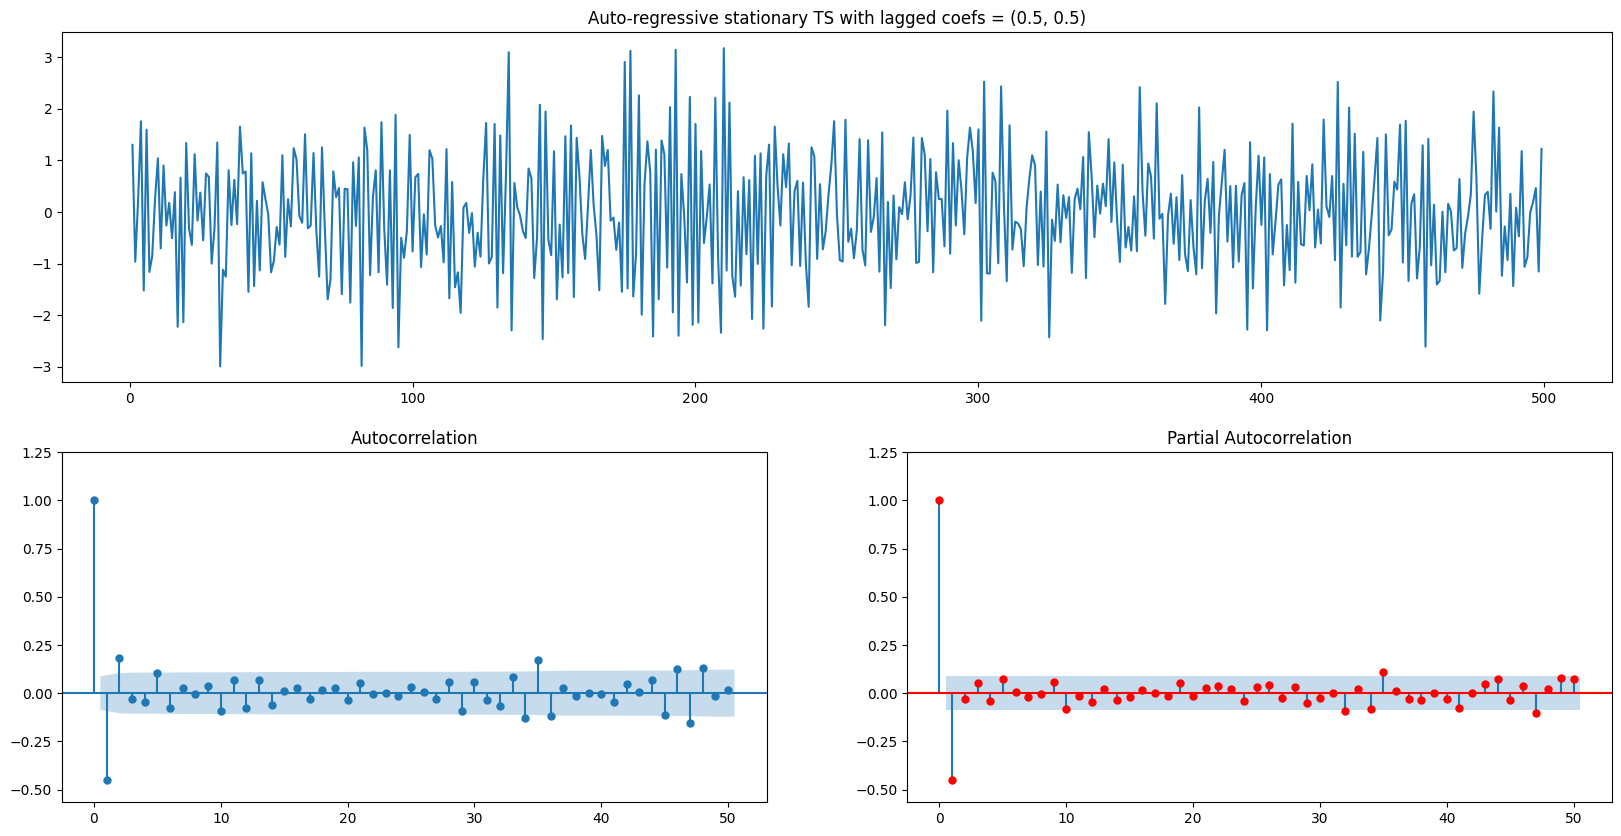

In [20]:
plot_ar_process(ar1=0.5,ar2=0.5, diff=1)

❓️ Questions:
1. Does this time series look stationary now?
2. Do you still see the AR(1) and AR(2) coefficients in the PACF?

<details>
    <summary>Answers</summary>
    
1. Yes it does!
2. The PACF shows a single negative peak of about -0.5. The ACF looks slightly oscillatory. The AR terms have been partially removed by differencing!
</details>

☝️ Think about it: 
- If each value of $y_t$ is approximately 0.5 times the value of $y_{t-1}$, removing a full value of $y_{t-1}$ from $y_t$ will result in a value of $y_t$ that is approximately $-0.5 * y_{t-1}$.

- The time series now behaves like a time series with AR(1) = -0.5. This leads to oscillatory behavior in the ACF (the peaks flip signs and decrease by about 0.5 for each lag).

☝️ Did we difference enough ([rules 1 & 2](http://people.duke.edu/~rnau/arimrule.htm) of the Box-Jenkins method)?
- When the diff still has **positive** ACF terms, we talk about slight **under-differencing**: when modelling an ARIMA on it, we would have to account for these positive terms as AR terms and set the `p` hyperparameter accordingly.  

- Here, we have **negative** ACF terms, meaning we have slightly **over-differenced** our time series. These terms can be accounted for with MA terms setting the `q` hyperparameter accordingly, as we will see in next challenge.



Now let's talk about MA processes!

## 2. MA (Moving-Average) Processes

$\color{blue}{MA}$ processes are a linear combination of $\color{blue}{q}$ prediction errors $\epsilon$ from a previous model (for instance, a linear trend, or an AR model). 

MA processes do not depend on previous values of y directly

$$ \large Y_t = \mu + \epsilon_t + \color{blue}{\phi_1} \epsilon_{t-1} + \color{blue}{\phi_2} \epsilon_{t-2} + \dots + \color{blue}{\phi_q} \epsilon_{t-q}$$

📺 [First, watch this 5min example of MA process: change in lemonade demand](https://www.youtube.com/watch?v=lUhtcP2SUsg)



In an $\color{red}{AR}$ process, disturbances (changes to Y) can propagate infinitely far into the future

> One example is sea levels: if sea levels rise by 5 cm this year, next year's sea levels will obviously depend on the new absolute sea level and not just the change in sea level.

**$\color{blue}{MA}$ disturbances have a finite lifetime and don't propagate far into the future**. They measure the effects of a limited-time duration (a "shock").

> In the example of sea levels, we could inspect the time series that represents the _changes_ in sea levels instead of the sea levels themselves. The _change_ in sea levels could be due to some external effect that we are not measuring, that is of finite duration, for example an extreme heat wave of a few years. This could lead to a few years of __above average increase__ in sea levels (our errors $\epsilon$). So for a few years, the values of _increase_ are correlated through some external process we don't know about. This will stop after a while, so the yearly _increase_ goes back to normal (and error $\epsilon$ goes back to 0), but the absolute sea level stays high.

☝️ Note that the change in sea levels can be considered as the _differenced_ time series of the original sea levels time series. As such, differencing can turn an AR model into an MA model!

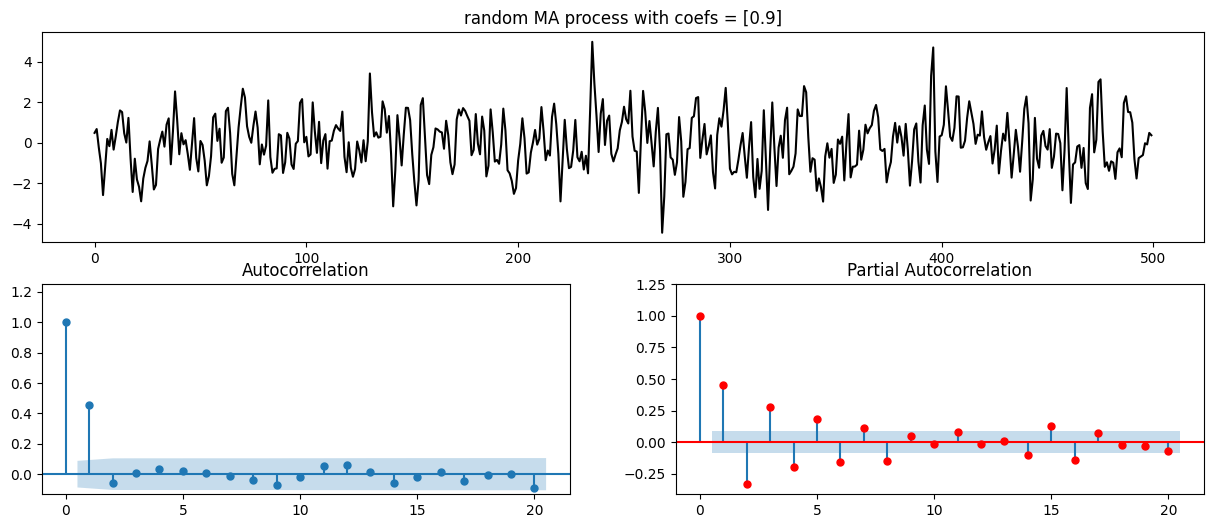

In [21]:
# We give you a random MA process generator (no need to look at the complex code for this challenge)
def ma_process(coef_list, n=200, show_plot=True, return_y=False):
    '''
    Generates an MA process from prediction error normally distributed
    '''

    X = np.arange(n)

    coef_list = [1]+coef_list
    coefs = np.asarray(coef_list)
    n_coef = len(coefs)

    noise_size = n + len(coefs)
    noise = np.random.normal(size=noise_size)

    # correlating random values with its immediate neighbors
    y_list = np.convolve(noise, coefs[::-1])[(n_coef-1):(n+n_coef-1)]

    if show_plot:
        fig = plt.figure(figsize=(20,10))

        ax1 = fig.add_subplot(2,1,1)
        ax1.set_title(f'MA TS with lagged coefs = {coef_list}')

        ax2 = fig.add_subplot(2,2,3)
        ax3 = fig.add_subplot(2,2,4)

        ax1.plot(X,y_list)

        plot_acf(y_list, lags=20, auto_ylims=True, ax=ax2);
        plot_pacf(y_list, lags=20, method='ywm', auto_ylims=True,ax=ax3, color='r');

        plt.show()

    if return_y:
        return y_list
    
# Note that we could also use STASTMODEL ARMAPROCESS GENERATOR instead
from statsmodels.tsa.arima_process import ArmaProcess
ar_terms = np.array([1])
ma_terms = np.array([1, 0.9])
sm_ma_process = ArmaProcess(ar=ar_terms, ma=ma_terms)
simulated_data = sm_ma_process.generate_sample(nsample=500)

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(2,1,1)
ax1.set_title(f'random MA process with coefs = {ma_terms[1:]}')
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)
ax1.plot(simulated_data, color='black')
plot_acf(simulated_data, lags=20, auto_ylims=True,ax=ax2);
plot_pacf(simulated_data, lags=20, method='ywm', auto_ylims=True, ax=ax3, color='r');

### Single MA Term

👇 Plot the curves for $\theta_1$ = 0.6 and n=200. You now have to pass the coefficients as a list!

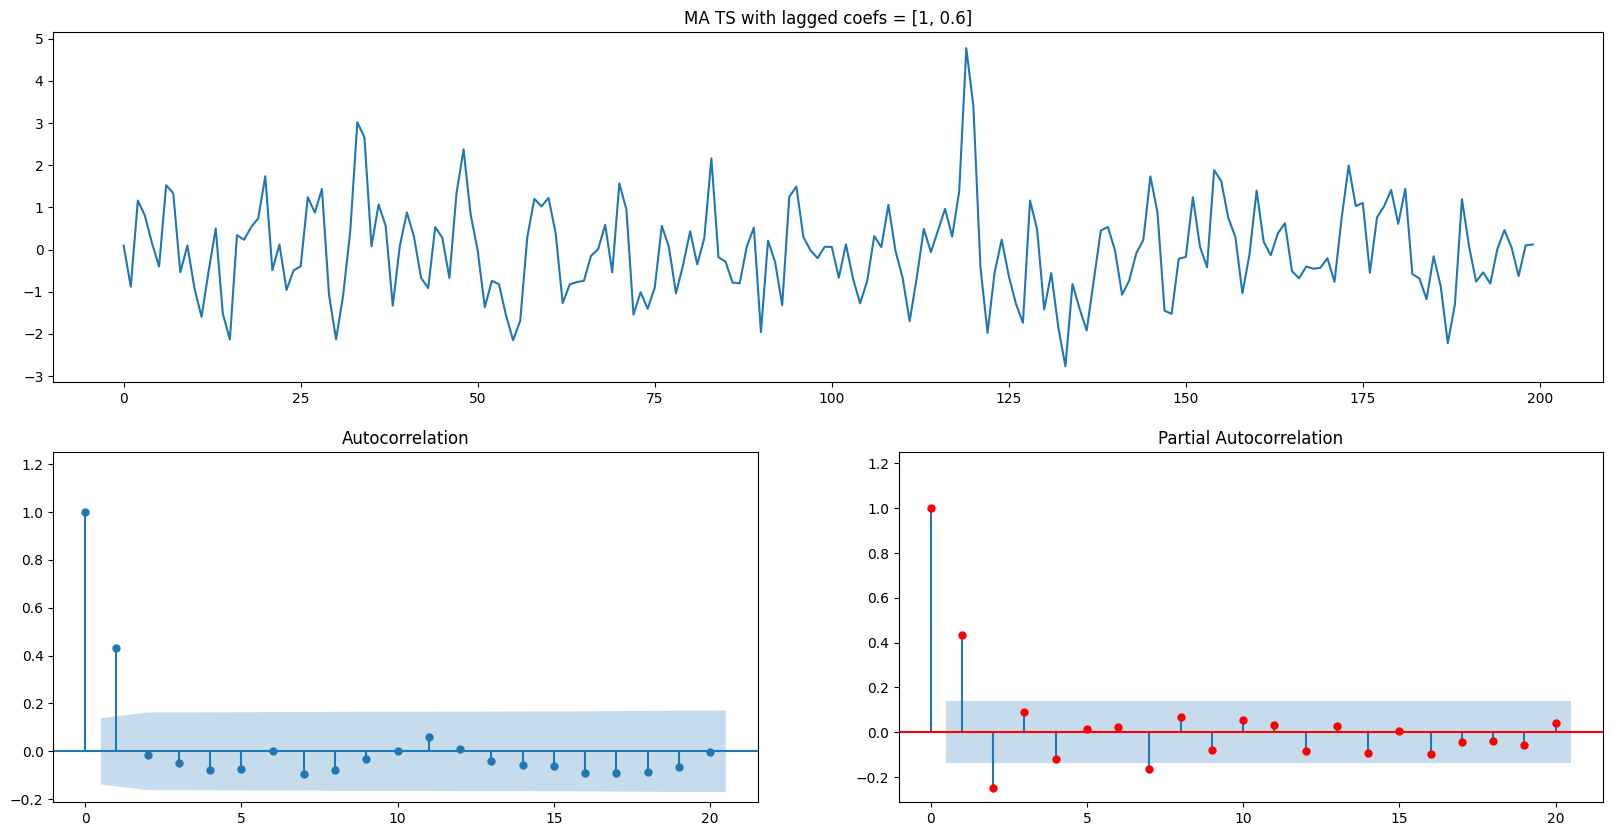

In [23]:
coef_list = [0.6]

ma_process(coef_list, n=200, show_plot=True, return_y=False)

Notice that MA processes are _always_ stationary.

❓️ Question: how does the ACF differ from an AR(1) process?

<details>
    <summary>Answer</summary>
The effect of the MA term does NOT propagate far into the future like for an AR term. It disappears after the first peak!

☝️ This is why we read the MA terms in the ACF and the AR terms in the PACF.
    
☝️ Sharp cut-offs in the ACF indicate MA processes in the absence of AR processes! [Rule 7](http://people.duke.edu/~rnau/arimrule.htm)

</details>

### Multiple MA Terms

👉 Now let's plot the same for three MA coefficients: [0.8, 0.2, 0.7] with `np.random.seed(2)`

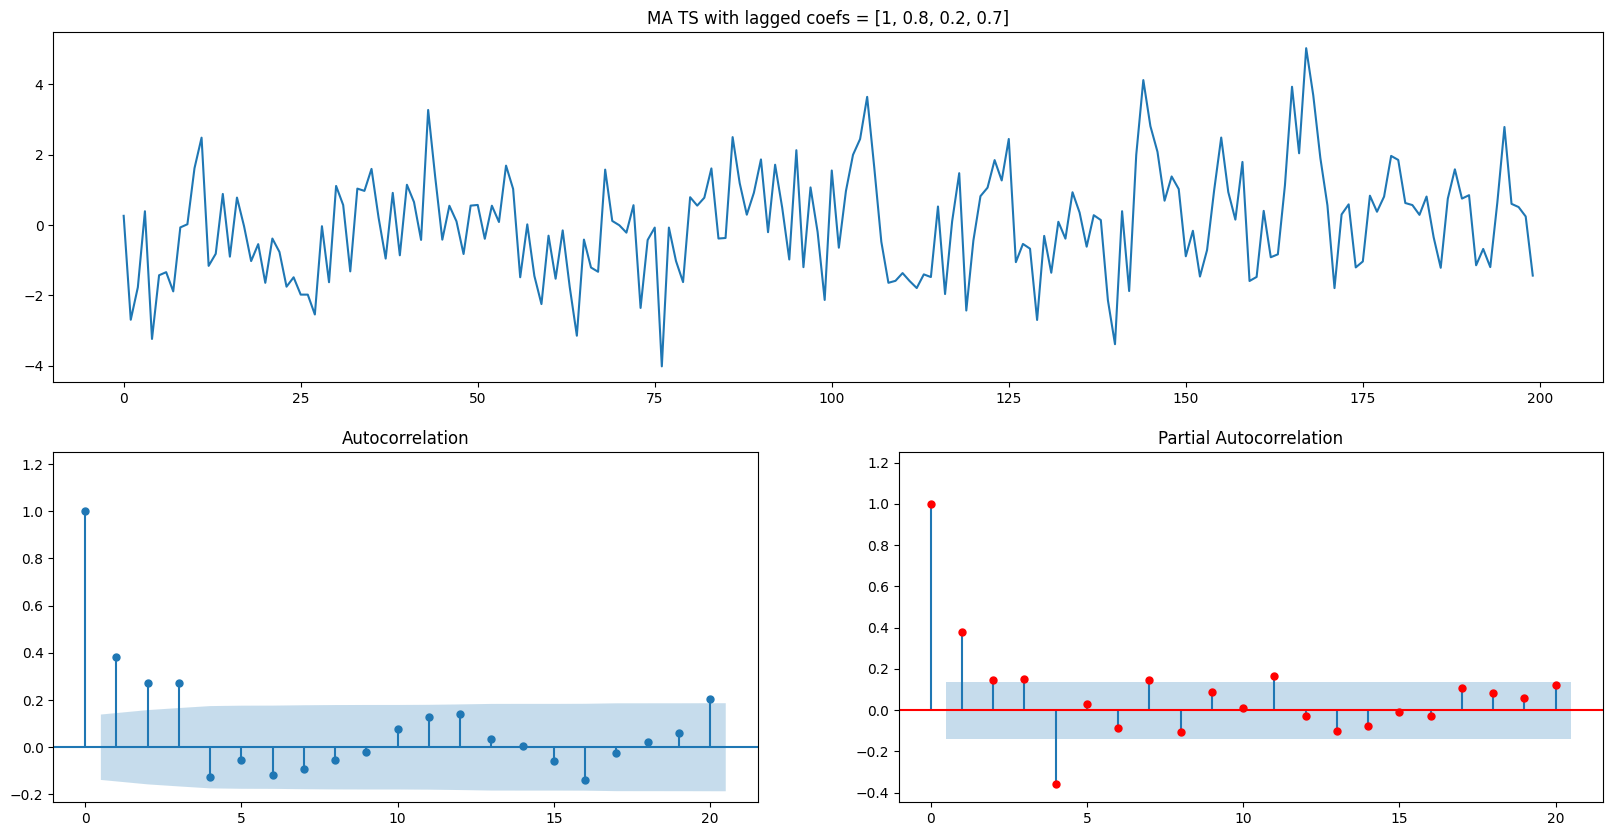

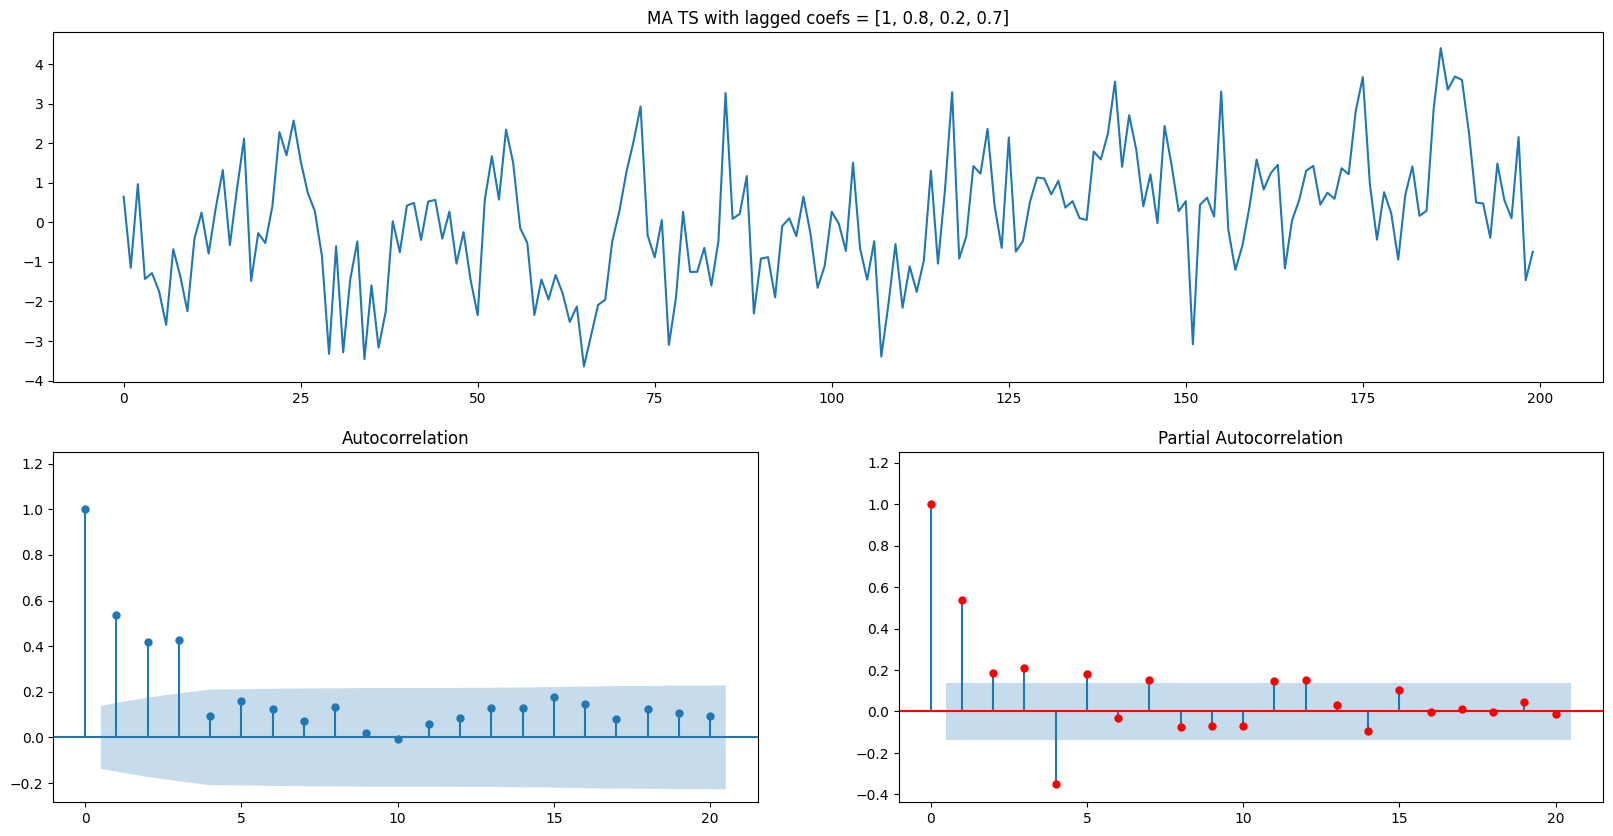

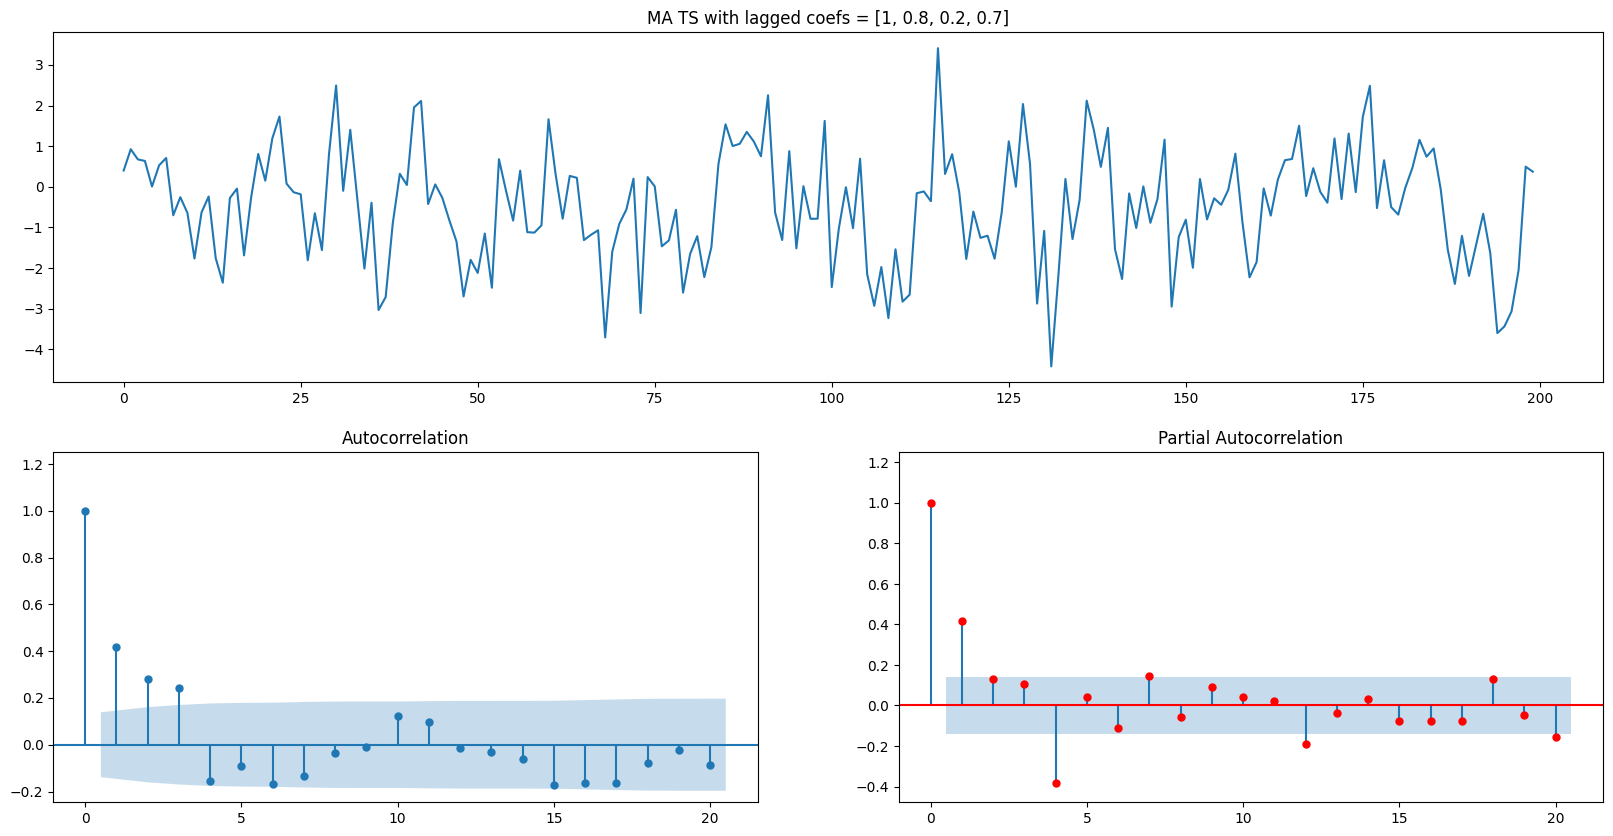

In [25]:
np.random.seed(2)

coef_list = [0.8, 0.2, 0.7]

for number in coef_list:
    ma_process(coef_list, n=200, show_plot=True, return_y=False)

☝️ As you can see, the PACF has become less useful for MA processes. We usually use the ACF to count the number of significant peaks to determine the order q of the MA model.

☝️ The size of the peaks is not very useful anymore to determine the size of the effect, but the number of significant peaks is.

Now let's mix AR and MA processes!

## 3. ARMA Processes

Now let's try and combine the two

$$Y_{t}=\color{red}{\beta_{1}}Y_{t-1}+\ldots+\color{red}{\beta_{p}}Y_{t-p}+\color{blue}{\phi_{1}}\epsilon_{t-1}
       +\ldots+\color{blue}{\phi_{q}}\epsilon_{t-q}+\epsilon_{t}$$
       
$\color{red}{AR(p)}$ terms in red, $\color{blue}{MA(q)}$ terms in blue.

### Creating an ARMA Process
👉 We will create an ARMA process with two AR and two MA terms. Note that we don't commonly deal with so many terms!

In [26]:
# Let's choose our AR and MA terms
ar_params = np.array([.55, -.35]) # beta
ma_params = np.array([.65, .95]) # phi

In [27]:
# Let's create an ARMA process using statsmodels dedicated library
from statsmodels.tsa.arima_process import ArmaProcess

ar = np.r_[1, -ar_params] # add zero-lag and negate (this is how ArmaProcess needs to be coded)
ma = np.r_[1, ma_params] # add zero-lag
arma_process = ArmaProcess(ar, ma)

In [28]:
# We then generate 200 data points of data from this ARMA process for now.
np.random.seed(1)
y = arma_process.generate_sample(200)

☝️ The sum of the AR coefficients is below 1, so it should be stationary; confirm it with an [ADF test](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).

In [30]:
from statsmodels.tsa.stattools import adfuller

adfuller(y)[1]

0.000367363746251949

### Inspecting the ARMA Time Series

👉 Plot the data

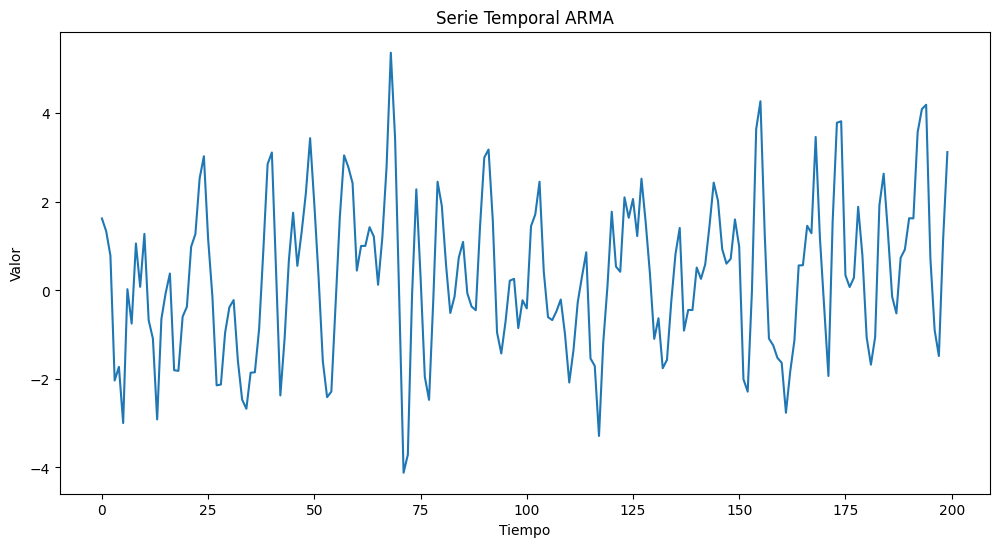

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(y)
plt.title("Serie Temporal ARMA")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.show()

👉 Plot the ACF and PACF

/Users/juancorrea/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


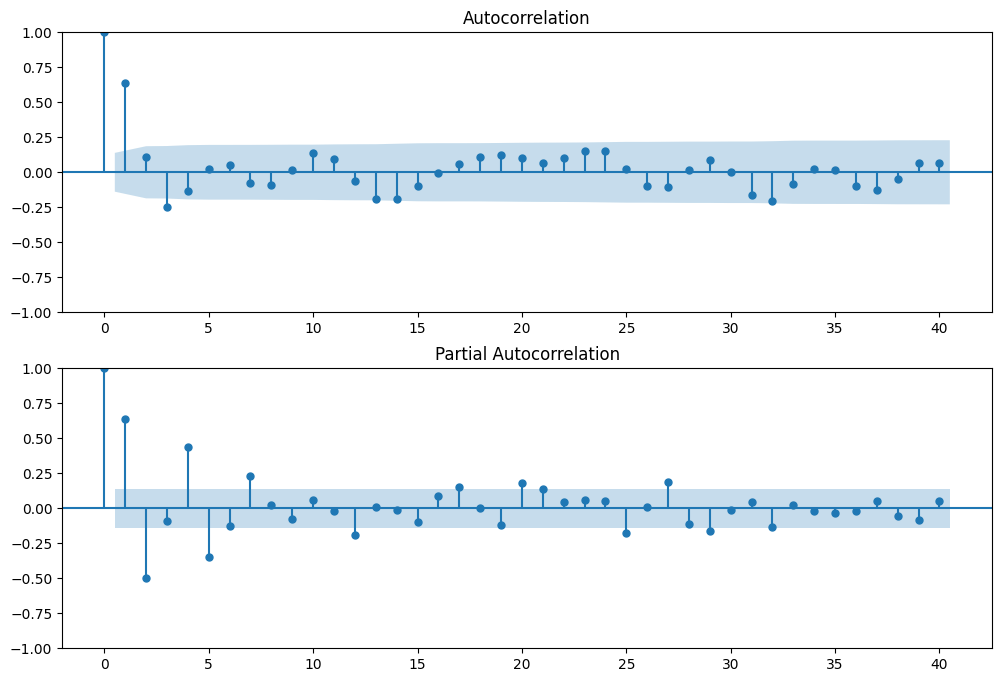

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(y, lags=40, ax=ax1)
plot_pacf(y, lags=40, ax=ax2)

plt.show()

☝️ In theory we should find
- AR terms = [.55, -.35] on the PACF
- MA terms = [.65, .95] on the ACF

☝️ We don't exactly find them all: as you can see, mixing several MA and AR terms complicates things as they interact and create strange artifacts. Differencing time series with trends also often creates strange artifacts.

**Optional:** try to create a non-stationary time series by setting the AR terms to add up to approximately 1. Warning: if they exceed 1 by more than just a bit, the time series will explode to infinity very quickly. Simple differencing won't help much anymore! Try to make the time series stationary by differencing and fitting an ARIMA model.)

### Fitting the Model Manually

For now, let's try and fit an ARIMA with 2 AR terms (as seen in the PACF) and 1 MA term (ACF), even though we know that's not the true model, since we created the model with 2 AR and 2 MA terms. This probably won't work well because the ACF now has mixed effects of several AR and MA terms.

👉 Fit an [ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) model with p=2, d=0, q=1

In [37]:
from statsmodels.tsa.arima.model import ARIMA

p = 2  # Orden AR
d = 0  # Orden de diferenciación
q = 1  # Orden MA

model = ARIMA(y, order=(p, d, q))
model_fit = model.fit()

👉 Inspect the AIC, the coefficients, and their p-values with `model.summary()`

In [38]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -312.894
Date:                Tue, 31 Oct 2023   AIC                            635.788
Time:                        21:19:01   BIC                            652.279
Sample:                             0   HQIC                           642.461
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3384      0.146      2.314      0.021       0.052       0.625
ar.L1          1.0199      0.122      8.389      0.000       0.782       1.258
ar.L2         -0.5388      0.092     -5.884      0.0

We have an **AIC of 635.788**.

☝️ The summary of the model seems to suggest that the MA term is not even significant (large p-value).

### Removing Non-Significant Coefficients

Will it get better if we remove the MA term (we want AIC to be low)?

👉 Fit an ARIMA with parameters (2, 0, 0) and see if the AIC improves.

In [40]:

p = 2  # Orden AR
d = 0  # Orden de diferenciación
q = 0  # Orden MA

model = ARIMA(y, order=(p, d, q))
model_fit = model.fit()

aic = model_fit.aic

print(model_fit.summary())



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -313.241
Date:                Tue, 31 Oct 2023   AIC                            634.481
Time:                        21:22:24   BIC                            647.674
Sample:                             0   HQIC                           639.820
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3391      0.152      2.229      0.026       0.041       0.637
ar.L1          0.9646      0.064     15.032      0.000       0.839       1.090
ar.L2         -0.5025      0.064     -7.899      0.0

❓️ Did the AIC improve?
<details>
    <summary>Answer</summary>
Not really! The AIC stayed about the same.
</details>

### Fitting the "True" Model

Let's try to fit the "true" model

👉 Fit an ARIMA with parameters (2, 0, 2) 

In [41]:
p = 2  # Orden AR
d = 0  # Orden de diferenciación
q = 2  # Orden MA

model = ARIMA(y, order=(p, d, q))
model_fit = model.fit()

aic = model_fit.aic

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -264.034
Date:                Tue, 31 Oct 2023   AIC                            540.067
Time:                        21:23:30   BIC                            559.857
Sample:                             0   HQIC                           548.076
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3421      0.177      1.936      0.053      -0.004       0.689
ar.L1          0.4846      0.076      6.399      0.000       0.336       0.633
ar.L2         -0.4296      0.071     -6.040      0.0

❓️ What do you notice (AIC, coefficients, and p-values)?

<details>
    <summary>Answer</summary>

Suddenly both MA terms are significant and the AIC has improved quite a bit (<b>AIC = 540</b>)! 

</details>

☝️ Unfortunately, for larger numbers of mixed AR and MA terms, the rules of thumb to find hyperparameters don't work so well anymore (see rule 8 in the [list of rules](http://people.duke.edu/~rnau/arimrule.htm)).

How would an automatic ARIMA fitting fare?

### Auto-ARIMA

👉 We'll use [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) to grid search values for p and q from 0 to 3. We won't use differencing or seasonal parameters (`d=None`, `seasonal=False`). We set `trace=True` to inspect results for different models tried.

In [42]:
! pip install pmdarima --quiet

In [43]:
import pmdarima as pm

model = pm.auto_arima(
    y, 
    start_p=0, start_q=0,
    max_p=3, max_q=3, # maximum p and q
    d = None,          # no diff
    seasonal=False
)   # no seasonality

In [44]:
# Print and inspect the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -262.938
Date:                Tue, 31 Oct 2023   AIC                            539.877
Time:                        21:25:38   BIC                            562.965
Sample:                             0   HQIC                           549.220
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3550      0.176      2.013      0.044       0.009       0.701
ar.L1          0.4217      0.079      5.343      0.000       0.267       0.576
ar.L2         -0.3526      0.077     -4.567      0.000      -0.504      -0.201
ar.L3         -0.1145      0.078     -1.474      0.141      -0.267       0.038
ma.L1          0.7003      0.030     23.046      0.000       0.641       0.760
ma.L2          0.9385      0.031     30.145      0.000       0.877       1.000
sigma2         0.7894      0.083      9.500      0.000       0.627       0.952
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.79   Prob(JB):                         0.89
Heteroskedasticity (H):               0.92   Skew:                            -0.06
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

❓️ Questions

1. What is the AIC value?
2. Did it find the "true" number of coefficients?
3. Are all p-values significant?
4. Do you see the "true" model in the trace? Look for it and its AIC.
5. Do other models have similar AIC values?

<details>
    <summary>Answer</summary>
    
1. We find an AIC of 539.9, which is close to what we just found for our "true" model
2. No, it found a better AIC for a model with 3 AR and 2 MA coefficients
3. The third AR coefficient does not seem to have a significant p-value, so we could decide to throw it out, which would give us back our "true" (2, 0, 2) model
4. As before, the "true" (2, 0, 2) model has an AIC of around 540 (541 this time), which is very close to the optimal model found by auto_arima
5. Several models tried have an AIC of around 540, of which our "true" model is the one with the lowest number of coefficients. When in doubt, pick the smaller model!

</details>

☝️ One of the reasons this model is hard to fit, is that we have multiple AR and MA terms, which is not very frequent with the right order of differencing to make your time series stationary. Additionally, we chose a model where the MA terms add up to more than 1, which is also uncommon if you use the right order of differencing. See rules 8-10 [here](http://people.duke.edu/~rnau/arimrule.htm).

☝️ Because of collinearity issues, models with many parameters can get tricky to solve clearly. Always compare a few combinations of hyperparameters (p, d, q) and when in doubt, choose the smaller model.

🏁️ You're done!
⚠️ Don't forget to push the challenge to GitHub 😄